In [159]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
from time import sleep
from ta.momentum import AwesomeOscillatorIndicator, StochasticOscillator, RSIIndicator
from ta.trend import MACD, CCIIndicator, EMAIndicator
from ta.volatility import BollingerBands
from ta.volume import ChaikinMoneyFlowIndicator
import warnings
warnings.filterwarnings('ignore')
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [160]:
data = pd.read_csv('.\data1mins.csv')

In [161]:
data

Loading ITables v2.5.2 from the internet... (need help?)


In [162]:
data.Date = pd.to_datetime(data.Date, errors = 'coerce')
data = data.set_index("Date")
data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
data = data.reset_index()

In [163]:
from scipy import signal
from scipy.signal import butter,lfilter 

def lowpass_filter_period_only(x, cutoff_period: int = 20, order: int = 2, zero_phase: bool = False):
    cutoff_period = max(int(cutoff_period), 3)  # kẹp tối thiểu 3
    Wn = 2.0 / float(cutoff_period)
    Wn = min(max(Wn, 1e-6), 0.999999)          # đảm bảo (0,1)
    sos = butter(order, Wn, btype="low", output="sos")
    if zero_phase:
        y = signal.sosfiltfilt(sos, pd.Series(x).values, method="gust")
    else:
        y = signal.sosfilt(sos, pd.Series(x).values)
    return pd.Series(y, index=pd.Series(x).index)


In [164]:
df = pd.read_csv('.\expiration_date.csv')
df.Date = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))
expiration_date

{datetime.date(2115, 9, 19),
 datetime.date(2043, 6, 18),
 datetime.date(2242, 10, 20),
 datetime.date(2156, 10, 21),
 datetime.date(2107, 9, 15),
 datetime.date(2151, 1, 21),
 datetime.date(2215, 11, 16),
 datetime.date(2203, 4, 21),
 datetime.date(2052, 7, 18),
 datetime.date(2081, 5, 15),
 datetime.date(2254, 10, 19),
 datetime.date(2033, 4, 21),
 datetime.date(2024, 7, 18),
 datetime.date(2177, 3, 20),
 datetime.date(2017, 1, 19),
 datetime.date(2097, 11, 21),
 datetime.date(2223, 5, 15),
 datetime.date(2041, 9, 19),
 datetime.date(2137, 1, 17),
 datetime.date(2103, 8, 16),
 datetime.date(2203, 6, 16),
 datetime.date(2138, 12, 18),
 datetime.date(2149, 6, 19),
 datetime.date(2055, 4, 15),
 datetime.date(2142, 12, 20),
 datetime.date(2141, 7, 20),
 datetime.date(2142, 4, 19),
 datetime.date(2032, 11, 18),
 datetime.date(2253, 1, 20),
 datetime.date(2033, 11, 17),
 datetime.date(2202, 5, 20),
 datetime.date(2242, 12, 15),
 datetime.date(2223, 8, 21),
 datetime.date(2223, 10, 16),
 da

In [165]:
def alpha(data, params):
    # Ensure data is a copy to avoid modifying the original
    data = data.copy()
    
    data['CCI'] = CCIIndicator(high=data['High'], low=data['Low'], close=data['Close'], window=params['cci_win']).cci()
    temp = StochasticOscillator(high=data['High'], low=data['Low'], close=data['Close'], window=params['sto_win'], smooth_window=params['smoo']).stoch()
    data['CMF'] = ChaikinMoneyFlowIndicator(high=data['High'], low = data['Low'], close = data['Close'], volume=data['Volume'], window = params['chai_win']).chaikin_money_flow()
    
    pos = 0
    position = []
    
    # If expiration_date is not provided, use an empty list
    expiration_date = params.get('expiration_date', [])
    
    for i in range(len(data)):
        CCI = data['CCI'].iat[i]
        STO = temp.iat[i]  # Get Stochastic Oscillator value
        vol_in = data['CMF'].iat[i] > 0
        vol_out = data['CMF'].iat[i] < 0
        
        if pos == 0:
            # Enter short: CCI oversold + Stochastic confirms oversold
            if CCI < params['t2'] and STO < params.get('sto_oversold') and vol_in:
                pos = -1
            # Enter long: CCI overbought + Stochastic confirms overbought
            elif CCI > params['t3'] and STO > params.get('sto_overbought') and vol_out:
                pos = 1
        elif pos == -1:
            # Exit short: CCI exit condition or Stochastic exits oversold
            if CCI > params['t4'] or STO > params.get('sto_exit_oversold'):
                pos = 0
        else:  # pos == 1
            # Exit long: CCI exit condition or Stochastic exits overbought
            if CCI < params['t5'] or STO < params.get('sto_exit_overbought'):
                pos = 0
                
        # Exit short at 14:25 (optional, end-of-day rule)
        if data['Date'].iloc[i].time() == datetime.time(14, 25):
            # Thoát short cuối ngày (CÓ THỂ HOẶC KHÔNG)
            if pos == -1:
                pos = 0
        if data['Date'].iloc[i].time() == datetime.time(14, 45):
            if len(position) > 0:
                # Reset vị thế ngày đáo hạn
                if data['Date'].iloc[i].date() in expiration_date:
                    pos = 0
        
        position.append(pos)
    
    # Add position column to DataFrame
    data['pos'] = position
    return data

In [166]:
# import optuna
# # === Metric & Backtest ===
# def compute_metrics(df, price_col='Close', pos_col='pos', slip_bps=1.0, fee_bps=1.0):
#     df = df.copy()
#     ret = df[price_col].pct_change().fillna(0.0)
#     pos = df[pos_col].fillna(0.0)
#     pos_shift = pos.shift(1).fillna(0.0)
#     strat_ret = ret * pos_shift
#     delta_pos = pos.diff().abs().fillna(0.0)
#     trade_cost = (slip_bps + fee_bps) / 10000.0
#     cost = delta_pos * trade_cost
#     strat_ret = strat_ret - cost
    
#     if 'Date' in df.columns:
#         day = pd.to_datetime(df['Date']).dt.date
#         daily_ret = strat_ret.groupby(day).sum()
#     else:
#         daily_ret = strat_ret
    
#     mean = daily_ret.mean()
#     std = daily_ret.std(ddof=1)
#     sharpe = 0.0 if std == 0 else (mean / std) * np.sqrt(252)
    
#     eq = (1 + daily_ret).cumprod()
#     dd = (eq.cummax() - eq) / eq.cummax()
#     mdd = dd.max() if len(dd) else 0.0
    
#     trades = int((delta_pos > 0).sum())
    
#     return {'sharpe': float(sharpe), 'mdd': float(mdd), 'trades': trades}

# # === Objective for Optuna ===
# def make_objective(data, base_params=None):
#     base_params = dict(base_params or {})
    
#     def objective(trial: optuna.Trial):
#         # Search space (all integers)
#         w1 = trial.suggest_int('w1', 10, 30)  # CCI window
#         cci = trial.suggest_int('cci', 10, 30)  # CCI window
#         t2 = trial.suggest_int('t2', 5, 40)   # CCI threshold to enter short
#         t3 = trial.suggest_int('t3', 60, 95)  # CCI threshold to enter long
#         t4 = trial.suggest_int('t4', t2 + 1, 85)  # CCI threshold to exit short (ensure t4 > t2)
#         t5 = trial.suggest_int('t5', 15, t3 - 1)  # CCI threshold to exit long (ensure t5 < t3)
        
#         smoo = trial.suggest_int('smoo', 1, 10)  
#         sto_win = trial.suggest_int('sto_win', 10, 40) 
#         sto_oversold = trial.suggest_int('sto_oversold', 10, 40) 
#         sto_overbought = trial.suggest_int('sto_overbought', 60, 100) 
#         sto_exit_oversold = trial.suggest_int('sto_exit_oversold', 30, 50)
#         sto_exit_overbought = trial.suggest_int('sto_exit_overbought', 50, 70)
        
#         rsi_win = trial.suggest_int('rsI_win', 10, 30)  # CCI window
#         rsi_t2 = trial.suggest_int('rsi_t2', 10, 45)   # CCI threshold to enter short
#         rsi_t3 = trial.suggest_int('rsi_t3', 60, 95)  # CCI threshold to enter long
#         rsi_t4 = trial.suggest_int('rsi_t4', 30, 70)  # CCI threshold to exit short (ensure t4 > t2)
#         rsi_t5 = trial.suggest_int('rsi_t5', 30, 70)  # CCI threshold to exit long (ensure t5 < t3)
        
#         chai_win = trial.suggest_int('chai_win', 5, 20)
        
        
        
#         # Parameters for alpha
#         params = {
#             't1': base_params.get('t1', 0.75),  # Keep t1 as float if required by lowpass filter
#             'w1': w1,
#             't2': t2, 't3': t3, 't4': t4, 't5': t5,
#             'cci_win': cci,
#             'smoo': smoo, 'sto_win': sto_win, 'sto_oversold': sto_oversold, 'sto_overbought': sto_overbought, 'sto_exit_oversold': sto_exit_oversold, 'sto_exit_overbought': sto_exit_overbought,
#             'rsi_t2': rsi_t2, 'rsi_t3': rsi_t3, 'rsi_t4': rsi_t4, 'rsi_t5': rsi_t5, 'rsi_win': rsi_win,
#             'chai_win': chai_win
#         }
        
#         # Run alpha function
#         df_pos = alpha(data, params)
        
#         # Calculate metrics
#         metrics = compute_metrics(df_pos, slip_bps=1.0, fee_bps=1.0)
#         score = metrics['sharpe']
        
#         # Penalty for low trades
#         if metrics['trades'] < 5:
#             score -= 0.5
        
#         # Optional: Penalize high drawdown
#         # score -= 0.5 * metrics['mdd']
        
#         trial.report(score, step=0)
#         return score
    
#     return objective

# # === Run Study ===
# sampler = optuna.samplers.TPESampler(seed=42, multivariate=True, group=True)
# pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)

# study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
# base_params = {
#     't1': 0.75, 't2': 31, 't3': 95, 't4': 84, 't5': 58, 'w1': 15, 'cci_win': 25, 
#     'smoo': 4, 'sto_win': 14, 'sto_oversold': 20, 'sto_overbought': 80, 'sto_exit_oversold': 40, 'sto_exit_overbought': 60,
#     'rsi_t2': 33, 'rsi_t3': 71, 'rsi_t4': 43, 'rsi_t5': 51, 'rsi_win': 10, 'chai_win': 14
#     }
# study.optimize(make_objective(data, base_params=base_params),
#                n_trials=200, show_progress_bar=True)

# print("Best Sharpe:", study.best_value)
# print("Best params:", study.best_params)

# # Backtest with best parameters
# best_params = base_params.copy()
# best_params.update(study.best_params)
# df_best = alpha(data, best_params)
# final = compute_metrics(df_best)
# print("Final metrics:", final)

In [167]:
params = {'w1': 11, 'cci_win': 14, 't2': 25, 't3': 74, 't4': 32, 't5': 28, 'smoo': 8, 'sto_win': 27, 'sto_oversold': 17, 'sto_overbought': 61, 'sto_exit_oversold': 42, 'sto_exit_overbought': 54, 'rsI_win': 18, 'rsi_t2': 37, 'rsi_t3': 71, 'rsi_t4': 61, 'rsi_t5': 69, 'chai_win': 15}

In [168]:
ds = alpha(data, params)
ds

Loading ITables v2.5.2 from the internet... (need help?)


Margin: 6.02
MDD: 88.5 (5.64%)

   Total trading quantity: 1212
         Profit per trade: 0.84
             Total Profit: 1608.5
         Profit after fee: 1012.6
 Trading quantity per day: 0.64
 Profit per day after fee: 0.53
                   Return: 0.08
          Profit per year: 132.9
                  HitRate: 0.37
          HitRate per day: 0.29


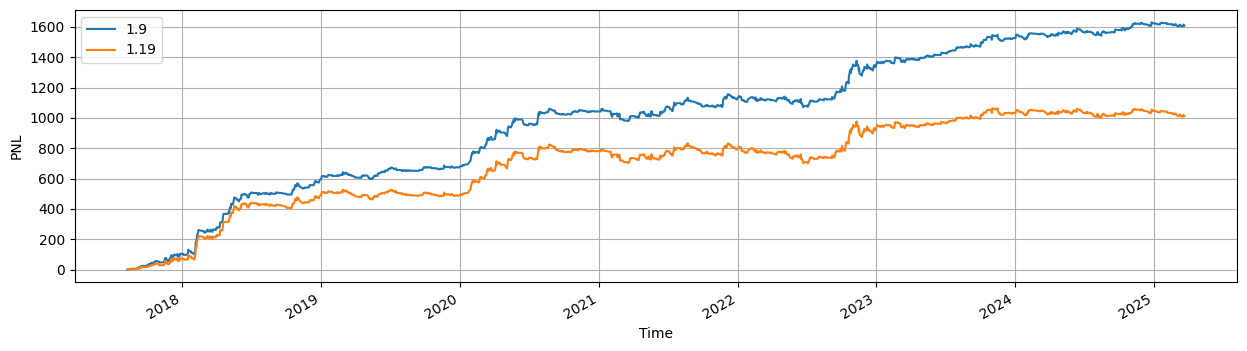

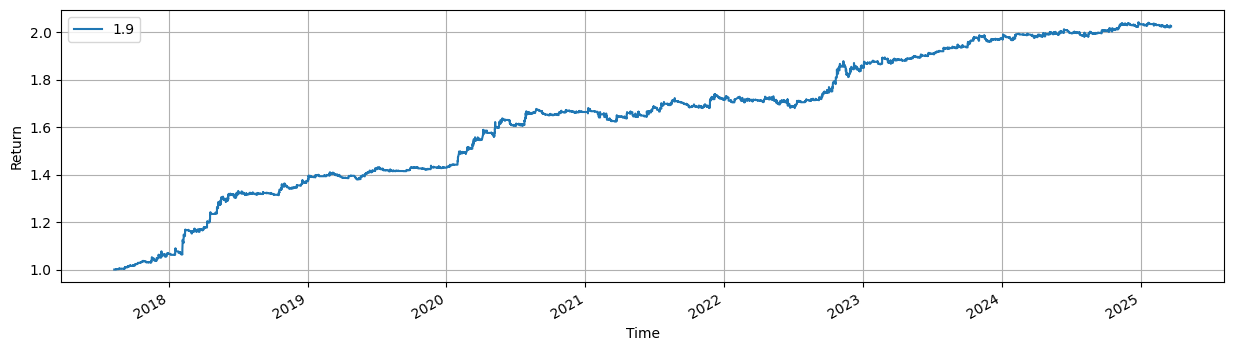

In [169]:
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3) 
pnl = backtestInfo.Plot_PNL()

In [170]:
# ds.pos

In [171]:
pnl

Loading ITables v2.5.2 from the internet... (need help?)


In [172]:
merged = pd.merge(ds, pnl, left_on="Date",right_on= "Datetime", how="inner")
merged

Loading ITables v2.5.2 from the internet... (need help?)


In [173]:
df = pd.DataFrame(ds)

# select Date and pos
df_result = df[["Date", "Close", "pos"]]
df_result

Loading ITables v2.5.2 from the internet... (need help?)


In [ ]:
# df_result.to_csv("alpha2_pos.csv", index=False)